In [1]:
import imageio

In [2]:
import czifile
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import time

In [3]:
fname = "500kStellateAstros_NucelofectionBacMam24hrs_Cal590-12_MIP.czi"

In [10]:
data1 = czifile.imread(fname).squeeze()

In [11]:
data2 = czifile.imread(fname).squeeze()

In [12]:
data1.shape

(224, 2, 2048, 1124)

In [14]:
np.concatenate([data1, data2], axis=0).shape

(448, 2, 2048, 1124)

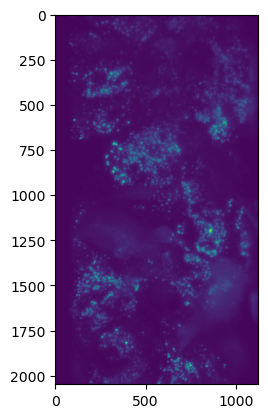

In [6]:
plt.imshow(data[10][0])

In [7]:
data.dtype

dtype('uint16')

## Dataloader

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [17]:
type([1]) == list

True

In [71]:
class CziVideoDataset(Dataset):
    def __init__(self, fpaths, frame_split=[16,16], n=0, channel=0):
        if(type(fpaths) == list):
            arrs = []
            for fpath in fpaths:
                data = czifile.imread(fpath).squeeze() # once we get multiple files, must combine
                arrs.append(data)
            data = np.concatenate(arrs, axis=0)
        else:
            data = czifile.imread(fpaths).squeeze()
    
        if(n>0): # if do not set, use entire dataset (like transformer)
            self.n = int(n) # n grams frame prediction
        else:
            self.n = 0
        
        print(f"Data with {len(data)} frames")
        self.patches_per_frame = frame_split[0] * frame_split[1]
        self.grid_size = frame_split
        self.frames = data[:,channel, :, :].astype(np.float32)
        self.frame_tensors = torch.tensor(self.frames, dtype=torch.float32).clone().detach()
    
    def __len__(self):
        # THIS MIGHT NOT BE TRUE
        # reasoning is that if 10 frames, trigram model, first frame possible is 8. (8,9), 10
        return((len(self.frames) - self.n + 1) * self.patches_per_frame)

    def __getitem__(self, idx):
        # indexes at max max-n frames
        first_frame = idx//self.patches_per_frame
        patch_index = idx%self.patches_per_frame
        print(f"first frame at {first_frame}, patch {patch_index}")
        if(self.n>0):
            Xs = []
            for i in range(self.n-1):
                patch = self.get_patch(first_frame+i, patch_index)
                print(patch.shape)
                Xs.append(patch)
            X = torch.cat(Xs, dim=0)
            print(X.shape)
            y = self.get_patch(first_frame + self.n - 1, patch_index) 
            return(torch.flatten(X), torch.flatten(y))
        else:
            raise NotImplementedError

    def get_patch(self, frame_index, patch):
        arr = self.frame_tensors[frame_index]
        assert patch < self.patches_per_frame, "Patch index out of range"
        height, width = arr.shape
        #print(height, width)
        row_size, col_size = int(height / self.grid_size[0]), int(width/self.grid_size[1])
        patch_row, patch_col = int(patch/self.grid_size[1]), patch%self.grid_size[1] # [0 1 2; 3 4 5; 6 7 8]
        #print(f"Row {patch_row}, ({row_size}px), Col {patch_col}, ({col_size}px)")
        return(arr[row_size*patch_row:row_size*(patch_row+1), col_size*patch_col:col_size*(patch_col+1)])

    def reshape_flattened(self, flattened_patch):
        # turn input flattened vector back into frames for viewing (heightxwidthxnum_frames)
        frame_height, frame_width = self.frames[0].shape
        patch_height, patch_width = frame_height // self.grid_size[0], frame_width // self.grid_size[1]
        return(flattened_patch.reshape([patch_height, patch_width, -1]))



In [68]:
%%time
ds = CziVideoDataset(fname, [16, 4], n=3)

Data with 224 frames
CPU times: user 1.37 s, sys: 6.81 s, total: 8.19 s
Wall time: 4.21 s


In [54]:
X, y = getitem(ds, 4)

first frame at 0, patch 4
torch.Size([128, 281])
torch.Size([128, 281])
torch.Size([256, 281])


In [76]:
len(ds)

14144

In [77]:
ds[100000]

first frame at 1562, patch 32


IndexError: index 1562 is out of bounds for dimension 0 with size 224

In [59]:
X.reshape([128, 281, -1]).shape

torch.Size([128, 281, 2])

In [54]:
dataloader = DataLoader(ds, batch_size=16, shuffle=True)

In [56]:
ds[10].shape

frame 0, patch 10


torch.Size([35968])

### Saving Videos

In [29]:
def save_as_video(self, output_path):
    s = time.time()
    # Define the video codec and frames per second (fps)
    height, width = self.frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    fps = 30
    # Create a VideoWriter object
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)
    for frame in self.frames:
        video_writer.write(frame)
    video_writer.release()
    
    print(f"Video saved to: {output_path} in {time.time() - s} seconds")

def save2(self, fname):
    fps = 30
    # Write frames to the video file
    with imageio.get_writer(fname, fps=fps) as writer:
        for frame in self.frames:
            writer.append_data(frame)
    print(f"Video saved to: {fname} in {time.time() - s} seconds")

In [15]:
fpath = "test.mp4"
fps = 30
with imageio.get_writer(fpath) as writer:
    writer.fps = fps  # Set the frame rate
    for frame in ds.frames[:10]:
        writer.append_data(frame)
    